# Step 1: 
### DATA preparation

### insert data and missing data check

In [3]:
#insert data

import pandas as pd
import numpy as np

Diabet = pd.read_csv("C:/Users/Administrator/git/Diabets/Diabetes Dataset/diabetes.csv")

In [5]:
Diabet.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [7]:
#Missing Datas

Diabet.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

##### no missing data so no handling

### Basic Info & Descriptive Stats

In [25]:
print("📌 Basic Info")
print(Diabet.info())

print("\n📌 First 5 rows")
print(Diabet.head())

print("\n📌 Descriptive Statistics")
print(Diabet.describe().T)  # transpose for easier reading

📌 Basic Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

📌 First 5 rows
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0


 -------------------------------------------------------------------------------------------------

 *** Glucose, BloodPressure, SkinThickness, Insulin, and BMI have minimum = 0.

 *** That’s not biologically realistic, so these are probably missing values coded as 0.

High variance / skewed features
Insulin has a huge standard deviation (115 vs mean 80) and goes up to 846 → very skewed.
Might need log transform or scaling.
Imbalanced Outcome
Mean of Outcome ≈ 0.35 → around 35% positive cases, 65% negative.
Not extremely imbalanced but something to keep in mind when evaluating models (use F1, not just accuracy).

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

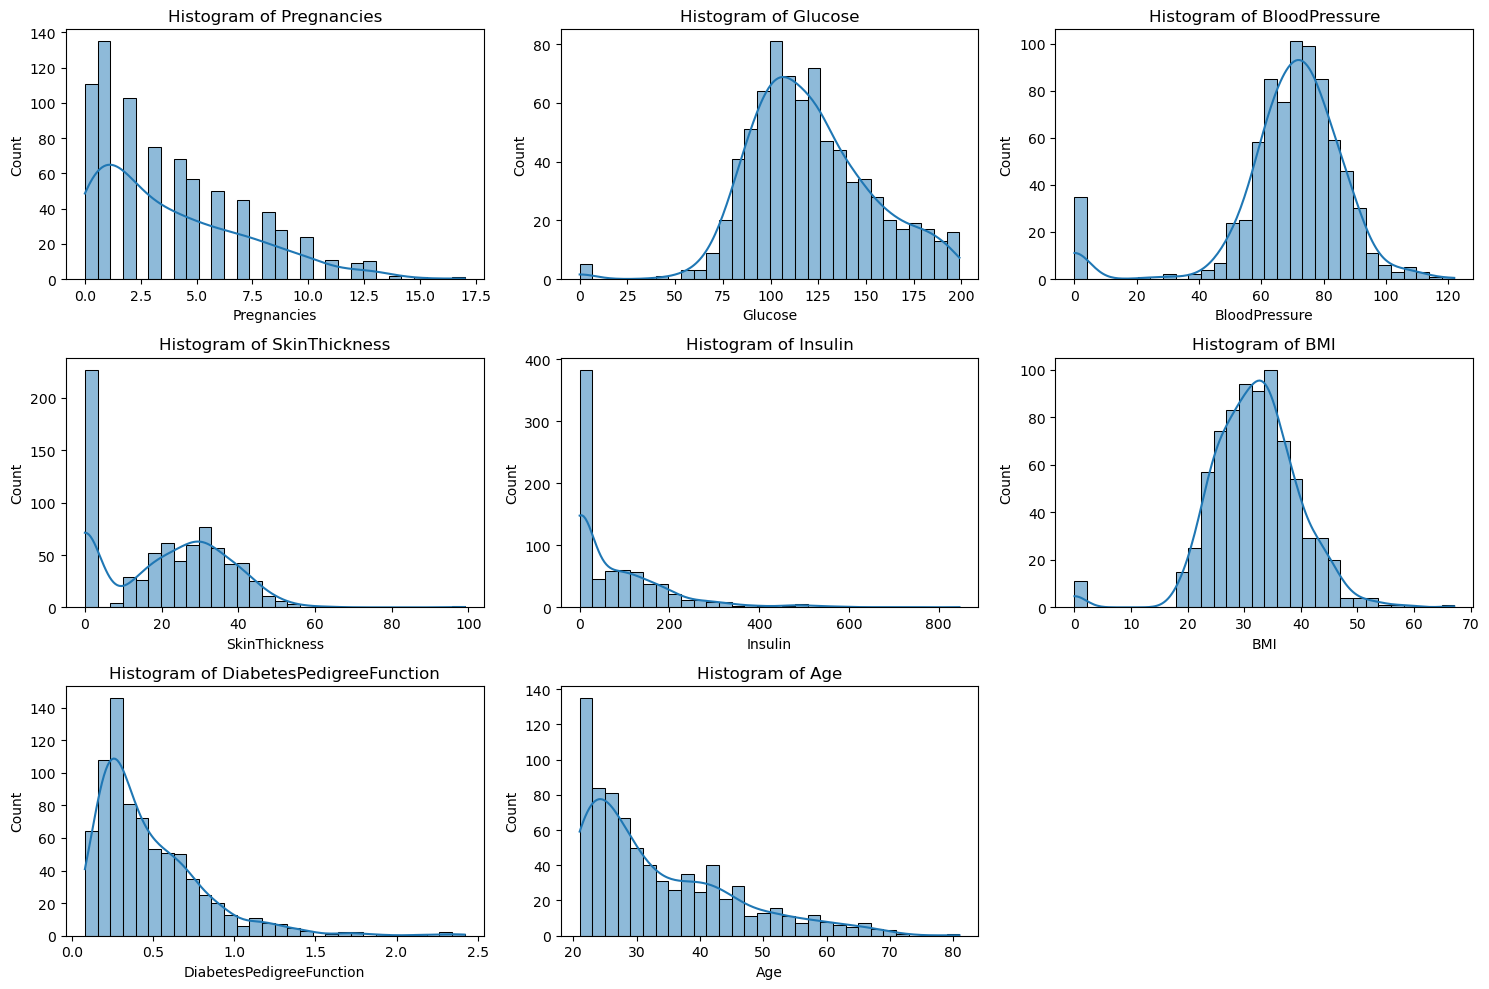

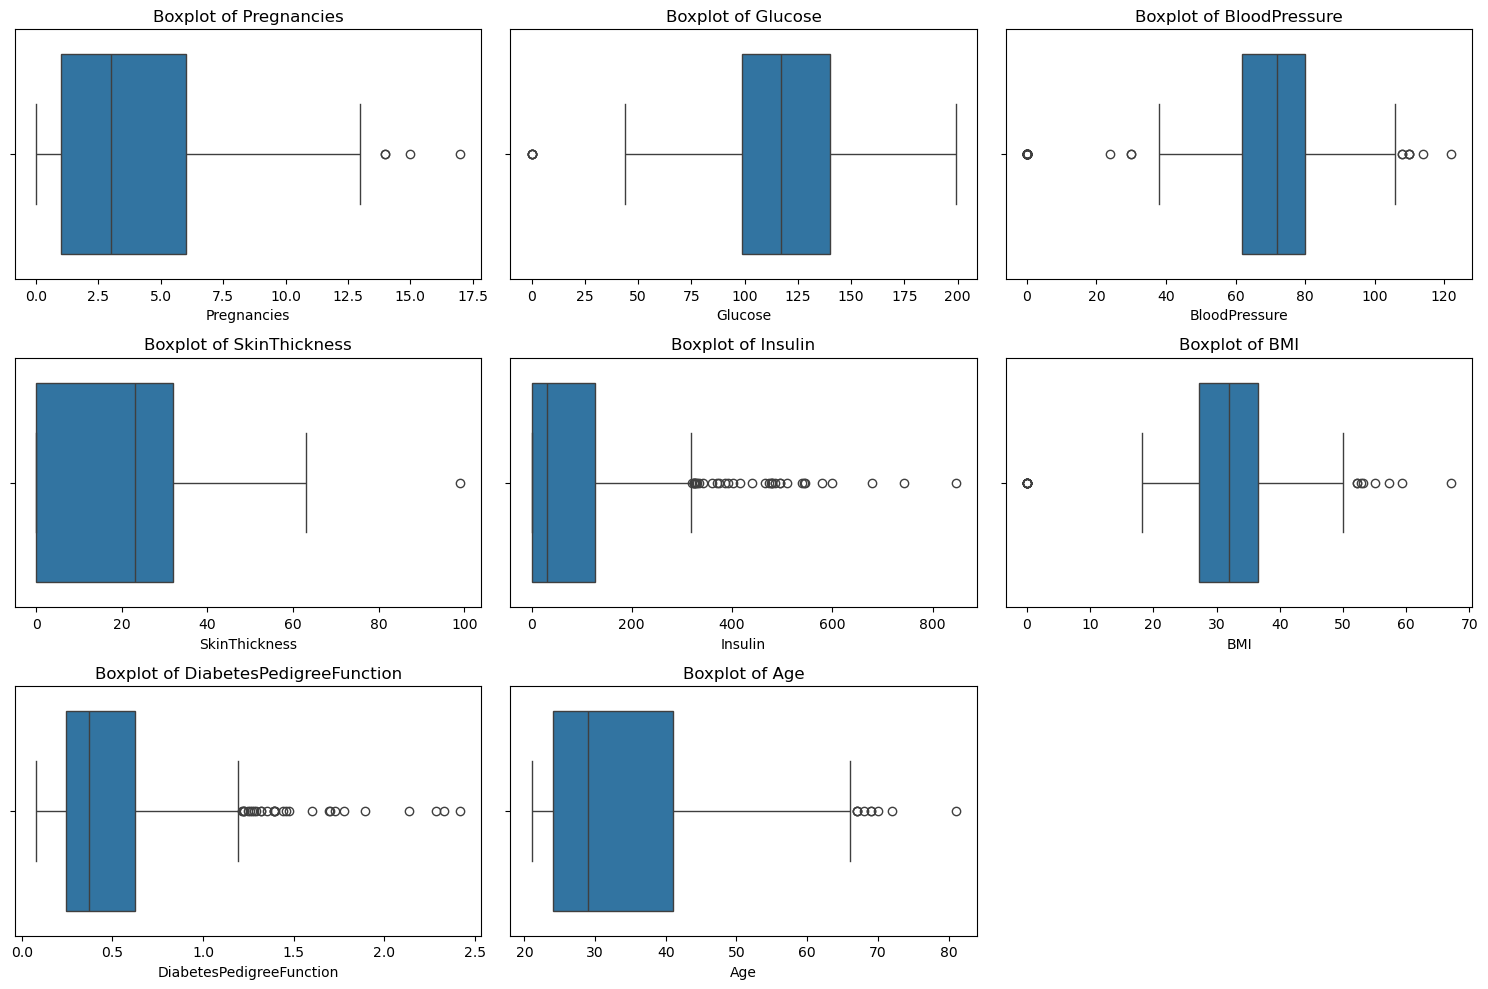

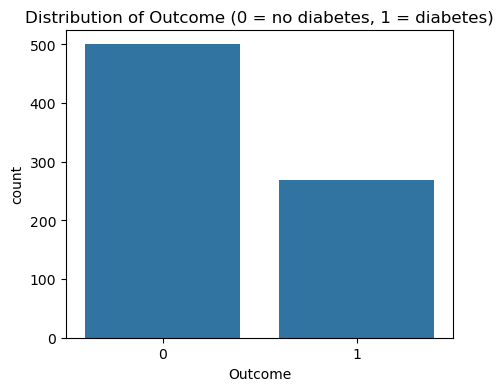

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select feature columns (exclude Outcome for now)
features = Diabet.columns.drop("Outcome")

# Histograms
plt.figure(figsize=(15, 10))
for i, col in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(Diabet[col], bins=30, kde=True)
    plt.title(f"Histogram of {col}")
plt.tight_layout()
plt.show()

# Boxplots
plt.figure(figsize=(15, 10))
for i, col in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=Diabet[col])
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

# Outcome distribution
plt.figure(figsize=(5, 4))
sns.countplot(x="Outcome", data=Diabet)
plt.title("Distribution of Outcome (0 = no diabetes, 1 = diabetes)")
plt.show()


### Noise Detection

In [38]:
# Columns where 0 should be considered missing
cols_with_missing = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# Replace 0 with NaN
Diabet[cols_with_missing] = Diabet[cols_with_missing].replace(0, np.nan)

# Check how many missing values we created
print(Diabet.isnull().sum())

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


### 80/20 split Data

In [42]:
from sklearn.model_selection import train_test_split

# Features and target
X = Diabet.drop("Outcome", axis=1)
y = Diabet["Outcome"]

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (614, 8) (614,)
Test shape: (154, 8) (154,)


### Missing values

In [46]:
# Count missing values in training data
print("Missing values in training set:")
print(X_train.isnull().sum())

Missing values in training set:
Pregnancies                   0
Glucose                       4
BloodPressure                23
SkinThickness               175
Insulin                     290
BMI                           9
DiabetesPedigreeFunction      0
Age                           0
dtype: int64


Glucose (4 missing) → very few, but Glucose is the most important clinical measure for diabetes → cannot just drop.

BloodPressure (23 missing) → still manageable but meaningful.

SkinThickness (175 missing, ~28% of train) → a lot missing, might be unreliable.

Insulin (290 missing, ~47% of train) → almost half missing, very risky.

BMI (9 missing) → important metabolic measure, easy to impute.

Pregnancies, DPF, Age → complete, no action needed.

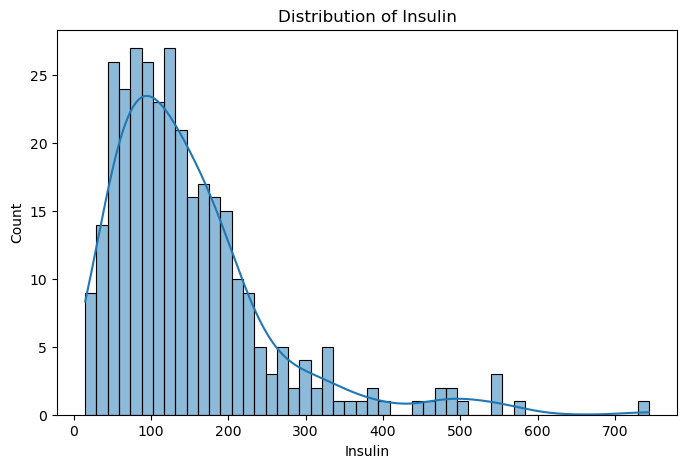

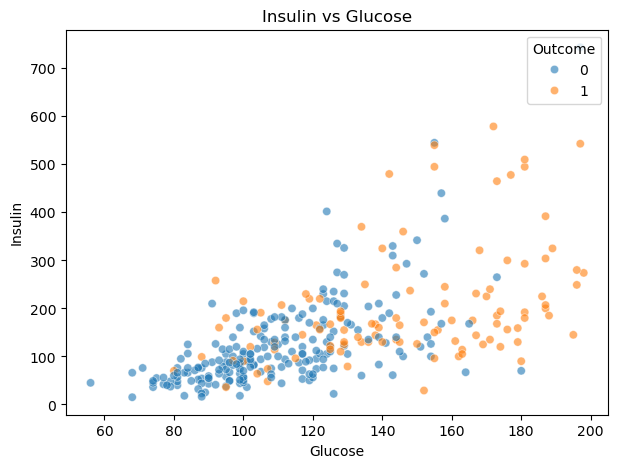

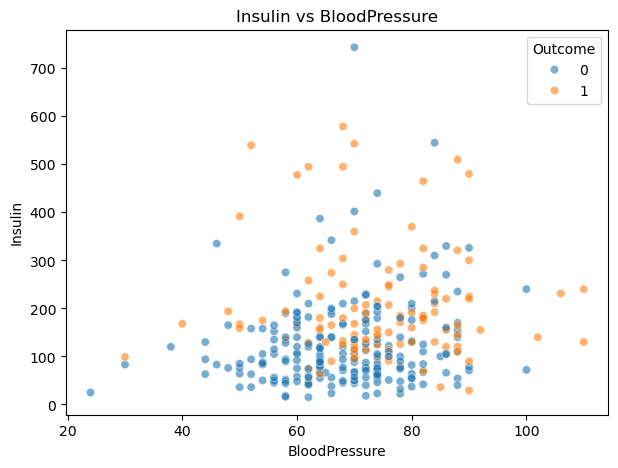

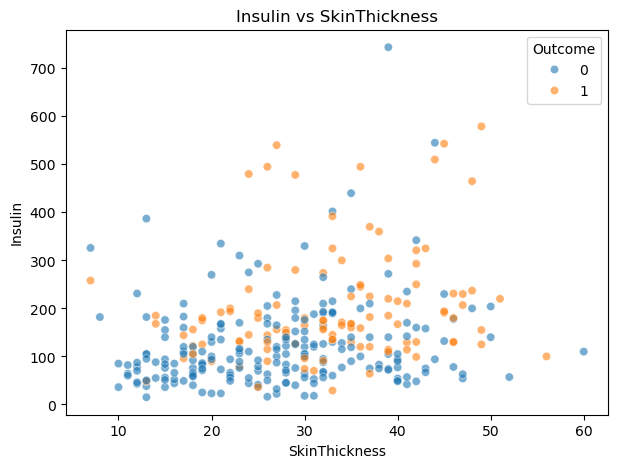

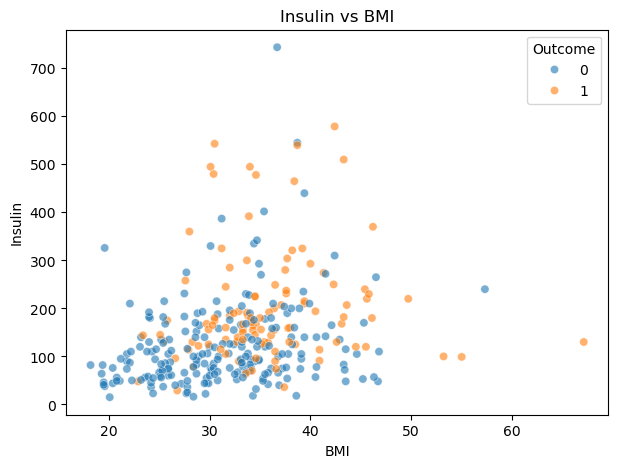

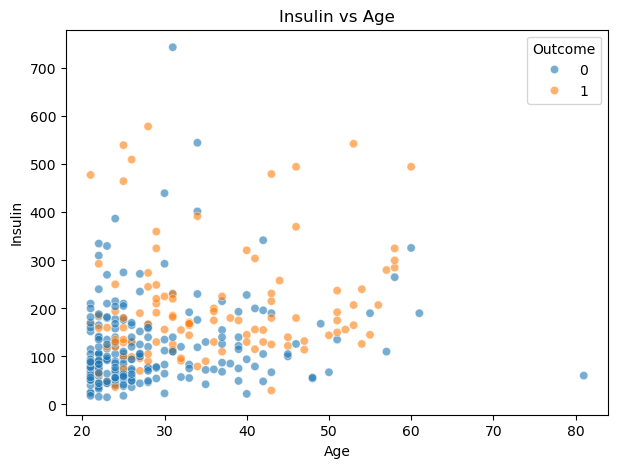

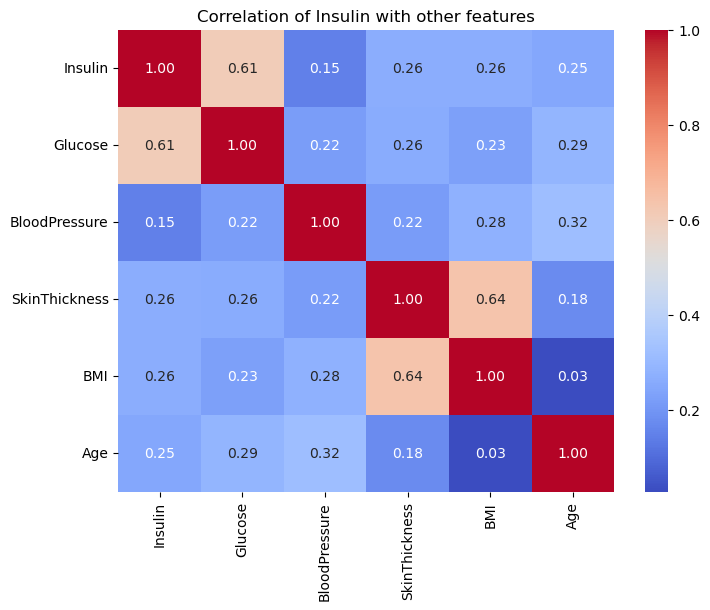

In [51]:
# Distribution of Insulin
plt.figure(figsize=(8,5))
sns.histplot(X_train["Insulin"].dropna(), bins=50, kde=True)
plt.title("Distribution of Insulin")
plt.xlabel("Insulin")
plt.ylabel("Count")
plt.show()

# Pairwise relationship with other numeric features
for col in ["Glucose", "BloodPressure", "SkinThickness", "BMI", "Age"]:
    plt.figure(figsize=(7,5))
    sns.scatterplot(x=X_train[col], y=X_train["Insulin"], hue=y_train, alpha=0.6)
    plt.title(f"Insulin vs {col}")
    plt.xlabel(col)
    plt.ylabel("Insulin")
    plt.legend(title="Outcome", loc="upper right")
    plt.show()

# Correlation heatmap including Insulin
plt.figure(figsize=(8,6))
corr = X_train[["Insulin","Glucose","BloodPressure","SkinThickness","BMI","Age"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation of Insulin with other features")
plt.show()

In [53]:
from sklearn.impute import KNNImputer
import numpy as np

# ---- 1. Median imputation for BMI, Glucose, BloodPressure ----
for col in ["BMI", "Glucose", "BloodPressure"]:
    median_val = X_train[col].median()
    X_train[col].fillna(median_val, inplace=True)

# ---- 2. KNN imputation for SkinThickness (exclude Insulin to avoid bias) ----
knn_st = KNNImputer(n_neighbors=5)
cols_st = [c for c in X_train.columns if c != "Insulin"]  # exclude Insulin
X_train[cols_st] = knn_st.fit_transform(X_train[cols_st])

# ---- 3. KNN imputation for Insulin (now include all features) ----
knn_all = KNNImputer(n_neighbors=5)
X_train[:] = knn_all.fit_transform(X_train)

# ---- 4. Check remaining missing values ----
print("Remaining missing values:\n", X_train.isnull().sum())


Remaining missing values:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64


C:\Users\Administrator\AppData\Local\Temp\ipykernel_8700\72361170.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[col].fillna(median_val, inplace=True)
